In the linear regression analysis for predicting the joint shear strength of fiber-reinforced concrete (FRC) beam-column connections, two distinct methodologies were employed: 
1) a mechanically consistent approach 
2) a mechanically inconsistent approach.

### Mechanically Consistent Approach:
This approach follows the methodology of Jiuru et al. (1992), ensuring that the units and physical relationships between input parameters are preserved. Input parameters are grouped into three distinct contributors (or sub-inputs). This design maintains the model's integrity, interpretability, and physical relevance.

### Mechanically Inconsistent Approach:
This approach assigns independent weights to each input parameter without considering their differing units. While this unconstrained method is expected to improve predictive accuracy, it lacks mechanical rationale and practical applicability. Despite achieving higher accuracy, the unit inconsistencies and lack of physical relevance render it unsuitable for meaningful insights into the behavior of structural connections.

## MULTIPLE LINEAR REGRESSION - METHOD 1 - MECHANICALLY CONSISTENT

In [8]:
# Import the necessary libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tabulate import tabulate
from IPython.display import display, Math
from scipy.optimize import minimize

In [9]:
# Define jitter function to reduce overlapping points (for visualization purposes that can be found below)
def add_jitter(values, scale=0.05):
    return values + np.random.uniform(-scale, scale, size=values.shape)

In [10]:
# Load the dataset with column names from the first row
data = pd.read_excel('../input_data/dataset.xlsx')

In [11]:
# Convert relevant columns to numeric to ensure proper data types (we already know the parameters to be included)
columns_to_check = ['n', 'sigcc', 'RI', 'jar', 'fy', 'rogross', 'gamma', 'jointtype']
for col in columns_to_check:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [12]:
# Calculate the 3 terms for the specified equation format
data['term_1_n_fc'] = data['gamma'] * (1 + 0.3 * data['n']) * data['sigcc']  # C1 * gamma * (1 + 0.3 * n) * sigcc
data['term_RI_fc'] = data['RI'] * data['sigcc'] / data['jar']  # C2 * RI * sigcc / jar
data['term_fy_A0'] = data['gamma'] * data['fy'] * data['rogross']  # C3 * gamma * fy * rogross

In [13]:
# Select the terms for the model
X = data[['term_1_n_fc', 'term_RI_fc', 'term_fy_A0']]
y = data['vj']

In [14]:
# Shuffle the dataset for randomness
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [15]:
# Calculate the number of rows for each subset
total_rows = data_shuffled.shape[0]
train_size = int(0.6 * total_rows)  # 60% for training
val_size = int(0.2 * total_rows)    # 20% for validation
test_size = total_rows - train_size - val_size  # 20% for test

In [16]:
# Manually slice the dataset
X_train = data_shuffled.iloc[:train_size][['term_1_n_fc', 'term_RI_fc', 'term_fy_A0']]
y_train = data_shuffled.iloc[:train_size]['vj']
X_val = data_shuffled.iloc[train_size:train_size + val_size][['term_1_n_fc', 'term_RI_fc', 'term_fy_A0']]
y_val = data_shuffled.iloc[train_size:train_size + val_size]['vj']
X_test = data_shuffled.iloc[train_size + val_size:][['term_1_n_fc', 'term_RI_fc', 'term_fy_A0']]
y_test = data_shuffled.iloc[train_size + val_size:]['vj']

In [17]:
# Create and train the final linear regression model
model = LinearRegression()
model.fit(X_train, y_train);

In [18]:
# Extracting the coefficients
C1, C2, C3 = model.coef_

In [19]:
# Make predictions using the 'production' approach for validation, test, and entire dataset
y_val_pred_production = (
    C1 * X_val['term_1_n_fc'] + 
    C2 * X_val['term_RI_fc'] + 
    C3 * X_val['term_fy_A0']
)
y_test_pred_production = (
    C1 * X_test['term_1_n_fc'] + 
    C2 * X_test['term_RI_fc'] + 
    C3 * X_test['term_fy_A0']
)
y_all_pred_production = (
    C1 * X['term_1_n_fc'] + 
    C2 * X['term_RI_fc'] + 
    C3 * X['term_fy_A0']
)

In [20]:
# Calculate the performance metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mpae = mean_absolute_percentage_error(y_true, y_pred) * 100
    r = np.corrcoef(y_true, y_pred)[0, 1]  # Correlation coefficient
    r2 = r2_score(y_true, y_pred)          # R-squared
    return mse, rmse, mpae, r, r2

In [21]:
# Metrics for validation, test, and entire dataset
mse_val, rmse_val, mpae_val, r_val, r2_val = calculate_metrics(y_val, y_val_pred_production)
mse_test, rmse_test, mpae_test, r_test, r2_test = calculate_metrics(y_test, y_test_pred_production)
mse_all, rmse_all, mpae_all, r_all, r2_all = calculate_metrics(y, y_all_pred_production)

In [22]:
# Data preparation
sample_counts = {
    'Training': [len(X_train)],
    'Validation': [len(X_val)],
    'Test': [len(X_test)]
}

samples_df = pd.DataFrame(sample_counts, index=['No. of Samples'])
print(tabulate(samples_df, headers='keys', tablefmt='grid'))

+----------------+------------+--------------+--------+
|                |   Training |   Validation |   Test |
+================+============+==============+========+
| No. of Samples |         79 |           26 |     27 |
+----------------+------------+--------------+--------+


In [23]:
results_df = pd.DataFrame({
    'Set': ['Validation', 'Entire Dataset'],
    'MSE': [round(mse_val, 2), round(mse_all, 2)],
    'RMSE': [round(rmse_val, 2), round(rmse_all, 2)],
    'MPAE (%)': [round(mpae_val, 2), round(mpae_all, 2)],
    'R': [round(r_val, 2), round(r_all, 2)],
    'R²': [round(r2_val, 2), round(r2_all, 2)]
})
table = tabulate(results_df, headers="keys", tablefmt="grid", showindex=False)
print("\nEvaluation Metrics (Production Approach):")
print(table)


Evaluation Metrics (Production Approach):
+----------------+-------+--------+------------+------+------+
| Set            |   MSE |   RMSE |   MPAE (%) |    R |   R² |
+================+=======+========+============+======+======+
| Validation     |  4.31 |   2.08 |      24.55 | 0.68 | 0.45 |
+----------------+-------+--------+------------+------+------+
| Entire Dataset |  3.52 |   1.88 |      28.6  | 0.79 | 0.52 |
+----------------+-------+--------+------------+------+------+


In [24]:
equation = r"V_j = \gamma \cdot {:.3f} \cdot (1 + 0.3 \cdot n) \cdot \sigma_{{cc}} + {:.3f} \cdot RI \cdot \frac{{\sigma_{{cc}}}}{{jar}} + \gamma \cdot {:.3f} \cdot f_{{y}} \cdot \rho_{{gross}}".format(C1, C2, C3)
display(Math(equation))

<IPython.core.display.Math object>

In [25]:
# Add jitter for better visualization
y_val_pred_jitter = add_jitter(y_val_pred_production, scale=0.01)
y_test_pred_jitter = add_jitter(y_test_pred_production, scale=0.01)
y_train_pred_jitter = add_jitter(model.predict(X_train), scale=0.01)

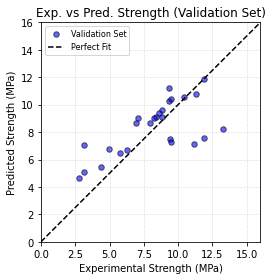

In [26]:
# Plot for validation set only
plt.figure(figsize=(4, 4))  # Smaller figure size
plt.scatter(y_val, y_val_pred_jitter, alpha=0.6, color='blue', label='Validation Set', s=30, edgecolors='k')
plt.plot([0, 16], [0, 16], 'k--', lw=1.5, label='Perfect Fit')  # Line of perfect fit
plt.xlim(0, 16)
plt.ylim(0, 16)
plt.xlabel('Experimental Strength (MPa)')  # Shortened label
plt.ylabel('Predicted Strength (MPa)')
plt.title('Exp. vs Pred. Strength (Validation Set)')  # Adjusted title
plt.legend(loc='upper left', fontsize=8)  # Smaller legend
plt.grid(True, linestyle=':', linewidth=0.5)  # Subtle gridlines
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()  # Ensure elements fit well
plt.savefig('../linear_regression_results/validation_plot_method1.png', dpi =1000)
plt.show()

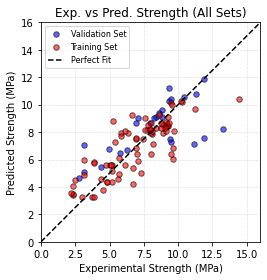

In [27]:
# Combined plot for validation, test, and training sets
plt.figure(figsize=(4, 4))  # Reduce the size of the figure
plt.scatter(y_val, y_val_pred_jitter, alpha=0.6, color='blue', label='Validation Set', s=30, edgecolors='k')
plt.scatter(y_train, y_train_pred_jitter, alpha=0.6, color='red', label='Training Set', s=30, edgecolors='k')
plt.plot([0, 16], [0, 16], 'k--', lw=1.5, label='Perfect Fit')  # Reduce line width
plt.xlim(0, 16)
plt.ylim(0, 16)
plt.xlabel('Experimental Strength (MPa)')  # Shorten labels
plt.ylabel('Predicted Strength (MPa)')
plt.title('Exp. vs Pred. Strength (All Sets)')  # Shorten title
plt.legend(loc='upper left', fontsize=8)  # Smaller legend
plt.grid(True, linestyle=':', linewidth=0.5)  # Subtle grid
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()  # Ensure all elements fit nicely
plt.savefig('../linear_regression_results/validation_training_plot_method1.png', dpi =1000)
plt.show()

## MULTIPLE LINEAR REGRESSION - METHOD 2 - MECHANICALLY INCONSISTENT

In [29]:
# Define jitter function to reduce overlapping points
def add_jitter(values, scale=0.01):
    return values + np.random.uniform(-scale, scale, size=values.shape)

In [30]:
# Convert relevant columns to numeric to ensure proper data types
columns_to_check = ['sigcc', 'Vf', 'AR', 'bb', 'bc', 'hb', 'hc', 'n', 'fy', 'rogross', 'gamma']
for col in columns_to_check:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [31]:
# Selecting the input features and the output
X = data[['sigcc', 'Vf', 'AR', 'bb', 'bc', 'hb', 'hc', 'n', 'fy', 'rogross']]
y = data['vj']
gamma = data['gamma']

In [32]:
# Define a function to fit linear regression with non-negative constraints
def constrained_linear_regaression(X, y, gamma):
    # Initial guess for coefficients
    initial_coeffs = np.ones(X.shape[1])

In [33]:
# Define a function to fit linear regression with non-negative constraints
def constrained_linear_regression(X, y, gamma):
    # Initial guess for coefficients
    initial_coeffs = np.ones(X.shape[1])

    # Define the objective function (MSE)
    def objective_function(coeffs):
        preds = gamma * np.dot(X, coeffs)
        mse = mean_squared_error(y, preds)
        return mse

    # Constraints: non-negative coefficients for specific variables
    constraints = [{'type': 'ineq', 'fun': lambda coeffs: coeffs[i]} 
                   for i in [0, 1, 2, 9]]  # Indices for 'sigcc', 'Vf', 'AR', 'rogross'

    # Minimize the objective function with constraints
    result = minimize(objective_function, initial_coeffs, constraints=constraints)

    return result.x  # Return the optimized coefficients

In [34]:
# Fit the model with constraints
optimized_coeffs = constrained_linear_regression(X, y, gamma)

In [35]:
# Calculating predictions for the entire dataset using the production equation
y_pred_production = gamma * np.dot(X, optimized_coeffs)

In [36]:
# Splitting the data into training, validation, and test sets (60/20/20)
X_train, X_temp, y_train, y_temp, gamma_train, gamma_temp = train_test_split(
    X, y, gamma, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test, gamma_val, gamma_test = train_test_split(
    X_temp, y_temp, gamma_temp, test_size=0.5, random_state=42)

In [37]:
# Predictions for validation and test sets
y_train_pred = gamma_train * np.dot(X_train, optimized_coeffs)
y_val_pred = gamma_val * np.dot(X_val, optimized_coeffs)
y_test_pred = gamma_test * np.dot(X_test, optimized_coeffs)

In [38]:
# Calculating performance metrics for validation and test sets
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)
mpae_val = np.mean(np.abs((y_val - y_val_pred) / y_val) * 100)
r_val = np.corrcoef(y_val, y_val_pred)[0, 1]  # Calculate R for validation set

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)
mpae_test = np.mean(np.abs((y_test - y_test_pred) / y_test) * 100)
r_test = np.corrcoef(y_test, y_test_pred)[0, 1]  # Calculate R for test set

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
mpae_train = np.mean(np.abs((y_train - y_train_pred) / y_train) * 100)
r_train = np.corrcoef(y_train, y_train_pred)[0, 1]  # Calculate R for training set

In [39]:
# Prepare the performance metrics
results_df = pd.DataFrame({
    'Set': ['Training', 'Validation'],
    'MSE': [mse_train, mse_val],
    'MPAE (%)': [mpae_train, mpae_val],
    'RMSE': [rmse_train, rmse_val],
    'R': [r_train, r_val],  # Include R
    'R²': [r2_train, r2_val]
})

# Format and display the table
print("\nPerformance Metrics:")
formatted_table = tabulate(results_df, headers='keys', tablefmt='grid', showindex=False, floatfmt=".2f")
print(formatted_table)



Performance Metrics:
+------------+-------+------------+--------+------+------+
| Set        |   MSE |   MPAE (%) |   RMSE |    R |   R² |
+============+=======+============+========+======+======+
| Training   |  1.68 |      18.12 |   1.30 | 0.91 | 0.80 |
+------------+-------+------------+--------+------+------+
| Validation |  1.90 |      15.51 |   1.38 | 0.75 | 0.49 |
+------------+-------+------------+--------+------+------+


In [40]:
coeff_names = ['sigcc', 'Vf', 'AR', 'bb', 'bc', 'hb', 'hc', 'n', 'fy', 'rogross']
table_data = [[name, f"{coeff:.3f}"] for name, coeff in zip(coeff_names, optimized_coeffs)]
print("\nOptimized Coefficients:")
print(tabulate(table_data, headers=["Coefficient", "Value"], tablefmt="grid"))


Optimized Coefficients:
+---------------+---------+
| Coefficient   |   Value |
+===============+=========+
| sigcc         |   1.366 |
+---------------+---------+
| Vf            |  50.593 |
+---------------+---------+
| AR            |   0.005 |
+---------------+---------+
| bb            |   0.018 |
+---------------+---------+
| bc            |  -0.011 |
+---------------+---------+
| hb            |  -0.024 |
+---------------+---------+
| hc            |   0.022 |
+---------------+---------+
| n             |   3.88  |
+---------------+---------+
| fy            |   0.001 |
+---------------+---------+
| rogross       |  -0     |
+---------------+---------+


In [41]:
# Define the coefficient names and optimized coefficients
coeff_names_latex = [
    r"\sigma_{cc}", r"V_{f}", r"AR", r"b_{b}",
    r"b_{c}", r"h_{b}", r"h_{c}", r"n", r"f_{y}", r"\rho_{gross}"
]
# Format each term of the equation using LaTeX
equation_terms = " + ".join([
    f"{coeff:.3f} \\cdot {name}" for coeff, name in zip(optimized_coeffs, coeff_names_latex)
])
# Create the full equation
equation = rf"V_j = \gamma \cdot \left[ {equation_terms} \right]"
# Display the equation
display(Math(equation))

<IPython.core.display.Math object>

In [42]:
# Plotting function for validation, test, and training sets
def plot_results(y_true, y_pred, title, color, label):
    plt.figure(figsize=(4, 4))
    plt.scatter(y_true, add_jitter(y_pred), alpha=0.6, color=color, label=label, s=50, edgecolors='k')
    plt.plot([0, 16], [0, 16], 'k--', lw=2, label='Perfect Fit')
    plt.xlim(0, 16)
    plt.ylim(0, 16)
    plt.xlabel('Experimental Joint Shear Strength')
    plt.ylabel('Predicted Joint Shear Strength')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('../linear_regression_results/validation_training_plot_method2.png', dpi =1000)
    plt.show()

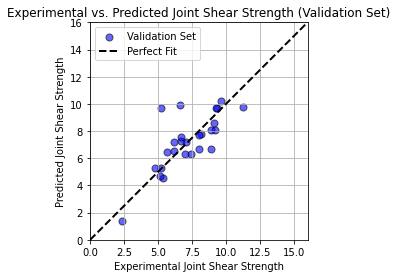

In [43]:
# Plotting validation results
plot_results(y_val, y_val_pred, 'Experimental vs. Predicted Joint Shear Strength (Validation Set)', 'blue', 'Validation Set')

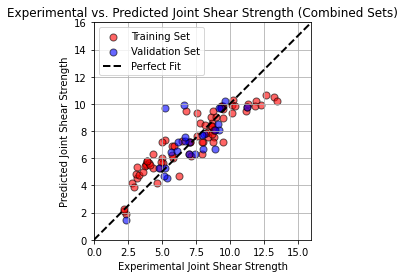

In [44]:
# Combined plot for training, validation, and test sets
plt.figure(figsize=(4, 4))
plt.scatter(y_train, add_jitter(y_train_pred), alpha=0.6, color='red', label='Training Set', s=50, edgecolors='k')
plt.scatter(y_val, add_jitter(y_val_pred), alpha=0.6, color='blue', label='Validation Set', s=50, edgecolors='k')
plt.plot([0, 16], [0, 16], 'k--', lw=2, label='Perfect Fit')
plt.xlim(0, 16)
plt.ylim(0, 16)
plt.xlabel('Experimental Joint Shear Strength')
plt.ylabel('Predicted Joint Shear Strength')
plt.title('Experimental vs. Predicted Joint Shear Strength (Combined Sets)')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('../linear_regression_results/validation_plot_method2.png', dpi =1000)
plt.show()